In [ ]:
#import all library needed
import pandas as pd
import torch
import math
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('UAS_ML2021_DATASET02.csv')
x = data[['Atribut_01', 'Atribut_02']].values

Dataset diatas dimsukkan ke dalam dataframe lalu featurenya dimasukkan ke dalam variable x.

In [ ]:
for l in [2, 3, 4, 5] :
  km = KMeans(n_clusters=l, random_state=1)

  km.fit_predict(data)

  score = metrics.silhouette_score(data, km.labels_, metric='euclidean')

  print('Silhouette Score k =',l,': %.3f' % score,)

Silhouette Score k = 2 : 0.662
Silhouette Score k = 3 : 0.732
Silhouette Score k = 4 : 0.602
Silhouette Score k = 5 : 0.584


Lalu variable x tersebut dimasukkan ke dalam KMeans library untuk di loop dengan angka 2-5 untuk mencari metric score dari setiap nilai k nya dengan score silhouette untuk mencari nilai k terbaik, dan didapatkan nilai k terbaik adalah 3 dengan silhouette score terbesar yaitu sebesar 0.732.

In [ ]:
x = StandardScaler().fit_transform(x)
x = torch.from_numpy(x).float()

In [ ]:
class KMeansClustering():
    
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.centroids = None
        
    
    def fit_transform(self, X, n_iter=20):
        size = X.shape[0]
        xmax = X.max(dim=0)[0].unsqueeze(1)
        xmin = X.min(dim=0)[0].unsqueeze(1)
        
        dists = torch.zeros((size, self.n_clusters))
        best_loss = 1e10
        pred = None
        
        for _ in range(n_iter):
            centroids = (xmin - xmax) * torch.rand((x.shape[1], self.n_clusters)) + xmax
            old_loss = -1
            while 1:
                for i in range(self.n_clusters):  
                    ctr = centroids[:, i].unsqueeze(1)
                    dists[:, i] = (X - ctr.T).pow(2).sum(dim=1).sqrt()
                dists_min, labels = dists.min(dim=1)
                
                for i in range(self.n_clusters): 
                    idx = torch.where(labels == i)[0]
                    if len(idx) == 0:
                        continue
                    centroids[:, i] = X[idx].mean(dim=0)
                    
                new_loss = dists_min.sum() 
                if old_loss == new_loss:
                    break
                old_loss = new_loss
            if new_loss < best_loss:
                best_loss = new_loss
                pred = labels
        return pred

Lalu class KMeansClustering dibuat dengan beberapa function di define didalamnya yaitu fit dan juga init dimana fit untuk memasukkan dataset nantinya ke dalam class atau function dan init untuk menentukan jumlah k nantinya, tujuan dari class KMeans itu sendiri adalah untuk membagi atau melakukan clustering nantinya terhadap data dengan label/class yang berbeda beda pada dataset.

In [ ]:
class GaussianMixture():
  
  def __init__(self, n_components, n_iter):
    self.n_components = n_components
    self.n_iter = n_iter
  
  def gaussian_likelihood(self, x, n):
    two_pi = torch.tensor(2 * math.pi, dtype=torch.float64)
    fact = 1 / torch.sqrt(torch.pow(two_pi, x.shape[0]) * torch.det(self.sigma[n]))
        
    x_minus_mu = x - self.mu[n].T
    sigma_inv = torch.inverse(self.sigma[n])
    return fact * torch.exp(-0.5 * x_minus_mu.mm(sigma_inv).mm(x_minus_mu.T))
  
  def e_step(self, x):
        for j in range(self.n_components):
            for i in range(self.n_samples):
                self.likelihoods[i, j] = self.gaussian_likelihood(x[i], j)
                
        
        prob_num = self.priors.T * self.likelihoods
        prob_den = prob_num.sum(dim=1).unsqueeze(1)
        self.probs = prob_num / prob_den
        
  def m_step(self, x):
    for j in range(self.n_components):
      probs_j = self.probs[:, j]
      probs_j_sum = probs_j.sum()
      self.priors[j] = probs_j.sum() / self.n_samples
      
      probs_j_uns = probs_j.unsqueeze(1)
      
      self.mu[j] = (probs_j_uns * x).sum(dim=0).unsqueeze(1)
      self.mu[j] /= probs_j_sum
  
      x_minus_mu = x - self.mu[j].T
      self.sigma[j].fill_(0.)
      for i in range(self.n_samples):
        row = x_minus_mu[i, :].unsqueeze(1)
        self.sigma[j] += probs_j[i] * row.mm(row.T)
      self.sigma[j] /= probs_j_sum
            
  def fit_predict(self, x):
    self.n_samples = x.shape[0]
    self.n_features = x.shape[1]
        
    self.sigma = torch.zeros((self.n_components, self.n_features, self.n_features), dtype=torch.float64)
    self.mu = torch.zeros((self.n_components, self.n_features, 1), dtype=torch.float64)
    self.priors = torch.zeros((self.n_components, 1), dtype=torch.float64).fill_(1 / self.n_components)
        
    kms = KMeansClustering(n_clusters=self.n_components)
    pred = kms.fit_transform(x).unsqueeze(1)
    self.probs = torch.zeros(self.n_samples, self.n_components)
    self.probs.scatter_(1, pred, 1)
        
    x_m = x - x.mean()
    x_cov = x_m.T.mm(x_m)
    for j in range(self.n_components):
      self.sigma[j] = x_cov.clone()
      self.mu[j] = x[torch.randint(0, self.n_samples, (1,))].T
        
    self.likelihoods = torch.zeros((self.n_samples, self.n_components), dtype=torch.float64)

    self.m_step(x)
    for _ in range(self.n_iter):
      self.e_step(x)
      self.m_step(x)
    return self.probs.argmax(dim=1)

Lalu class selanjutnya yang dibuat adalah gaussianmixture dimana itu adalah model yang akan digunakan untuk melakukan pembagian classifikasi nantinya pada dataset dimana didalamnya terdapat beberapa function seperti e step dan juga m step yang merupakan langkah - langkah didalam gaussianmixture, function gaussianlikelihood untuk mencari kesamaan terhadap suatu data atau neighbor dari setiap data itu sendiri, dan terakhir adalah function predict untuk memprediksi class atau bagian classifikasi dari suatu data pada dataset.

In [ ]:
gmm = GaussianMixture(n_components=3, n_iter=10)
pred_gmm = gmm.fit_predict(x)

Diatas gaussianmixture function dijalankan dengan jumlah k sebesar 3 dan jumlah iteration sebesar 10 dan predict juga dijalankan untuk keperluan evaluasi atau mencari akurasi nantinya.

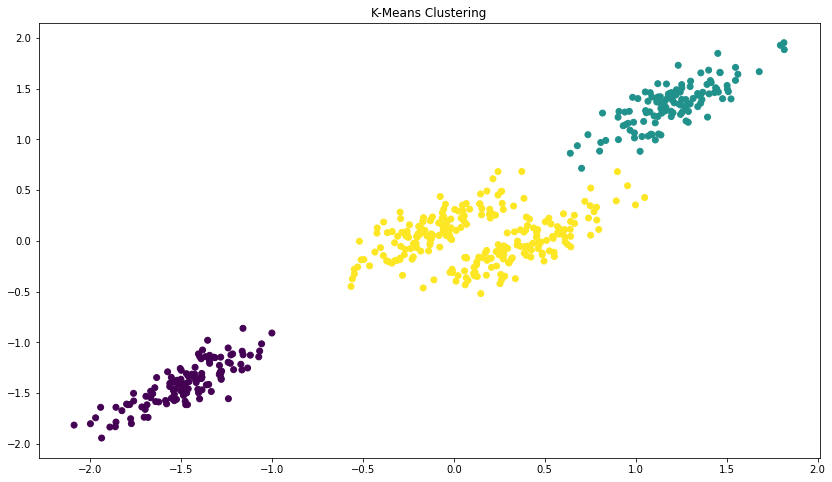

In [ ]:
# Menampilkan grafik K-Means Clustering
plt.figure(figsize = (14, 8))
plt.title('K-Means Clustering')
plt.scatter(x[:, 0], x[:, 1], c=pred_gmm)

Lalu setelah model sudah ditrain atau dijalankan dan klasifikasi sudah dilakukan maka plot akan dimunculkan untuk mengetahui hasil dari model dan dapat dilihat diatas model membagi class menjadi 3 dengan warna ungu, kuning, dan juga hijau dimana melambangkan 3 class yang berbeda yang didapat dengan melihat likelihood dari setiap data atau melihat neighbour dari setiap data. didalam dataset.

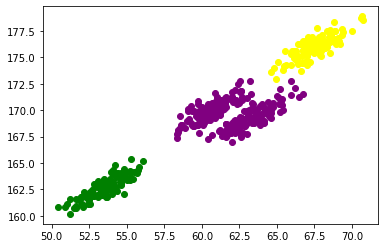

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(data)

#predictions from gmm
labels = gmm.predict(data)
frame = pd.DataFrame(data)
frame['cluster'] = labels
frame.columns = ['Weight', 'Height', 'cluster']

color=['purple','yellow','green']
for k in range(0,3):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Weight"],data["Height"],c=color[k])
plt.show()

Lalu disini hasil dari model dibandingkan dengan built-in function dari sklearn untuk GMM itu sendiri apakah model sudah cocok atau sama dengan built-in function atau tidak.